# Librerias

In [45]:
import pandas as pd
import numpy as np
import sys
sys.path.append('../')
import funciones as fun
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score, confusion_matrix
from sklearn.neighbors import KernelDensity
from sklearn.cluster import KMeans

## Lectura

In [23]:
df = pd.read_csv('../Datos/Originales/log2.csv')

In [24]:
df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


# Label encoder

In [25]:
df['Action'].unique()

array(['allow', 'drop', 'deny', 'reset-both'], dtype=object)

In [26]:
codificador = LabelEncoder()

# Aplicar el codificador a las columnas especificadas
columnas_a_codificar = ['Action']
for columna in columnas_a_codificar:
    df[columna + '_encoded'] = codificador.fit_transform(df[columna])

df.head()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action_encoded
0,57222,53,54587,53,allow,177,94,83,2,30,1,1,0
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9,0
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1,0
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7,0
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18,0


## Analisis manual

In [27]:
df, servicios_count = fun.map_ports_to_services(df, 'Source Port')
servicios_count

,Servicio,Frecuencia
0,Servicio desconocido,65158
1,https,273
2,http,46
3,imaps,19
4,printer,4
5,ms-olap2,4
6,netbios-ns,4
7,ssh,4
8,sms-remctrl,4
9,ms-olap4,3


In [28]:
df, servicios_count = fun.map_ports_to_services(df, 'Destination Port')
servicios_count

,Servicio,Frecuencia
0,Servicio desconocido,20594
1,domain,15414
2,microsoft-ds,12891
3,https,11684
4,http,4035
5,telnet,363
6,ms-wbt-server,176
7,ssh,119
8,ms-sql-s,66
9,imaps,40


In [29]:
df, servicios_count = fun.map_ports_to_services(df, 'NAT Source Port')
servicios_count

,Servicio,Frecuencia
0,Servicio desconocido,65492
1,ssh,4
2,ms-olap1,3
3,ms-cluster-net,3
4,http,2
5,https,2
6,smtp,2
7,ms-theater,1
8,dvcprov-port,1
9,dccm,1


In [30]:
df, servicios_count = fun.map_ports_to_services(df, 'NAT Destination Port')
servicios_count

,Servicio,Frecuencia
0,Servicio desconocido,34429
1,domain,15094
2,https,11678
3,http,4028
4,ms-wbt-server,156
5,ssh,43
6,imaps,38
7,telnet,16
8,smtp,14
9,teredo,10


### Estanzarizar

In [31]:
df_numerico = df.select_dtypes(include='number')

In [32]:
scaler = MinMaxScaler()
df_selected_scaled = scaler.fit_transform(df_numerico)

### PCA

In [33]:
pca = PCA(n_components=0.95)
principal_components = pca.fit_transform(df_selected_scaled)
components_df = pd.DataFrame(data=principal_components)

### Train - Test

In [34]:
train_data, test_data = train_test_split(components_df, test_size=0.2, random_state=42)

In [35]:
print("Forma del conjunto de entrenamiento:", train_data.shape)
print("Forma del conjunto de prueba:", test_data.shape)

Forma del conjunto de entrenamiento: (52425, 4)
Forma del conjunto de prueba: (13107, 4)


# Detección anomalías

## Isolation Forest

In [36]:
isolation_forest = IsolationForest(n_estimators=100, contamination=0.2, random_state=42)
train_data['Anomaly_IF'] = isolation_forest.fit_predict(train_data)
test_data['Anomaly_IF'] = isolation_forest.predict(test_data)
train_data['Anomaly_IF'] = train_data['Anomaly_IF'].apply(lambda x: 1 if x == -1 else 0)
test_data['Anomaly_IF'] = test_data['Anomaly_IF'].apply(lambda x: 1 if x == -1 else 0)

num_anomalias = (train_data['Anomaly_IF'] == 1).sum()
num_anomalias += (test_data['Anomaly_IF'] == 1).sum()
print("Número de anomalías detectadas:", num_anomalias)

Número de anomalías detectadas: 13191


### One-Class SVM

In [37]:
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.2)
ocsvm.fit(train_data.drop(columns='Anomaly_IF'))
train_data['Anomaly_OCSVM'] = ocsvm.predict(train_data.drop(columns='Anomaly_IF'))
test_data['Anomaly_OCSVM'] = ocsvm.predict(test_data.drop(columns='Anomaly_IF'))
train_data['Anomaly_OCSVM'] = train_data['Anomaly_OCSVM'].apply(lambda x: 1 if x == -1 else 0)
test_data['Anomaly_OCSVM'] = test_data['Anomaly_OCSVM'].apply(lambda x: 1 if x == -1 else 0)

num_anomalias = (train_data['Anomaly_OCSVM'] == 1).sum()
num_anomalias += (test_data['Anomaly_OCSVM'] == 1).sum()
print("Número de anomalías detectadas:", num_anomalias)

Número de anomalías detectadas: 13188


### Combinación

In [38]:
combined_data = pd.concat([train_data, test_data])

### Comparación de resultados

In [39]:
anomaly_counts = pd.DataFrame({
    'Model': ['Isolation Forest', 'Isolation Forest', 'One-Class SVM', 'One-Class SVM'],
    'Anomaly': ['Normal', 'Anomaly', 'Normal', 'Anomaly'],
    'Count': [
        (combined_data['Anomaly_IF'] == 0).sum(),
        (combined_data['Anomaly_IF'] == 1).sum(),
        (combined_data['Anomaly_OCSVM'] == 0).sum(),
        (combined_data['Anomaly_OCSVM'] == 1).sum()
    ]
})

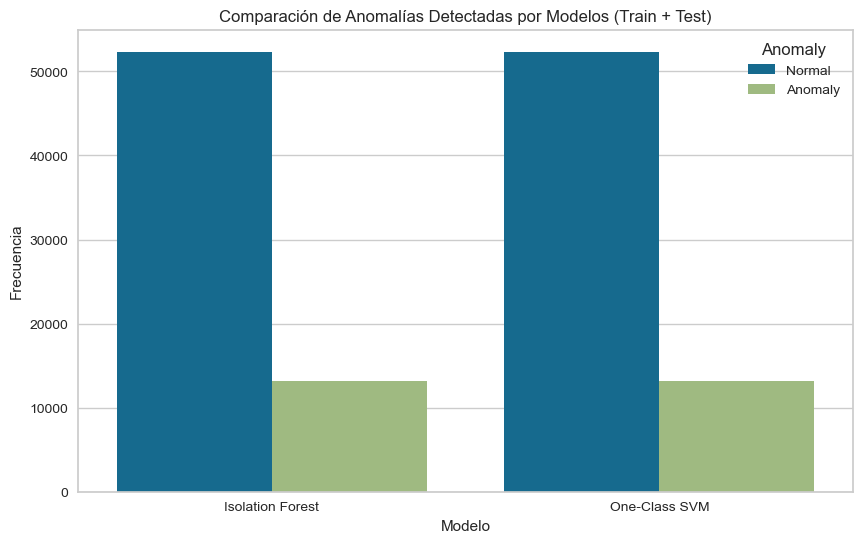

In [40]:
# Gráfico de barras para comparación de anomalías detectadas
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='Count', hue='Anomaly', data=anomaly_counts)
plt.title('Comparación de Anomalías Detectadas por Modelos (Train + Test)')
plt.xlabel('Modelo')
plt.ylabel('Frecuencia')
plt.show()

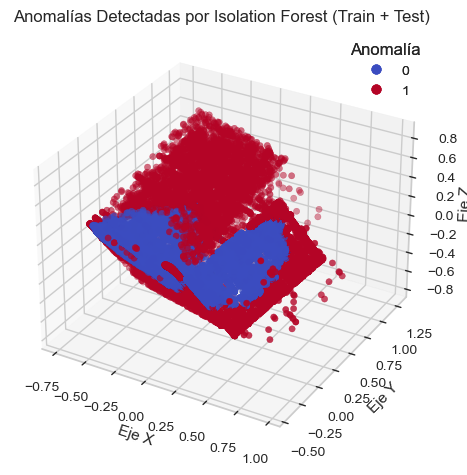

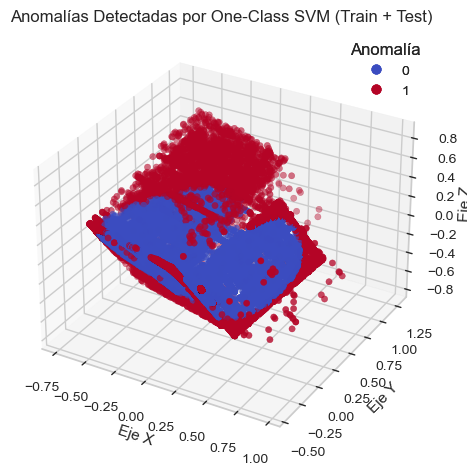

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Gráfico 3D para anomalías detectadas por Isolation Forest
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(combined_data.iloc[:, 0], combined_data.iloc[:, 1], combined_data.iloc[:, 2], c=combined_data['Anomaly_IF'], cmap='coolwarm')
ax.set_title('Anomalías Detectadas por Isolation Forest (Train + Test)')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
legend = ax.legend(*scatter.legend_elements(), title="Anomalía")
ax.add_artist(legend)
plt.show()
# Agregar la leyenda



# Gráfico 3D para anomalías detectadas por One-Class SVM
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(combined_data.iloc[:, 0], combined_data.iloc[:, 1], combined_data.iloc[:, 2], c=combined_data['Anomaly_OCSVM'], cmap='coolwarm')
ax.set_title('Anomalías Detectadas por One-Class SVM (Train + Test)')
ax.set_xlabel('Eje X')
ax.set_ylabel('Eje Y')
ax.set_zlabel('Eje Z')
legend = ax.legend(*scatter.legend_elements(), title="Anomalía")
ax.add_artist(legend)
plt.show()

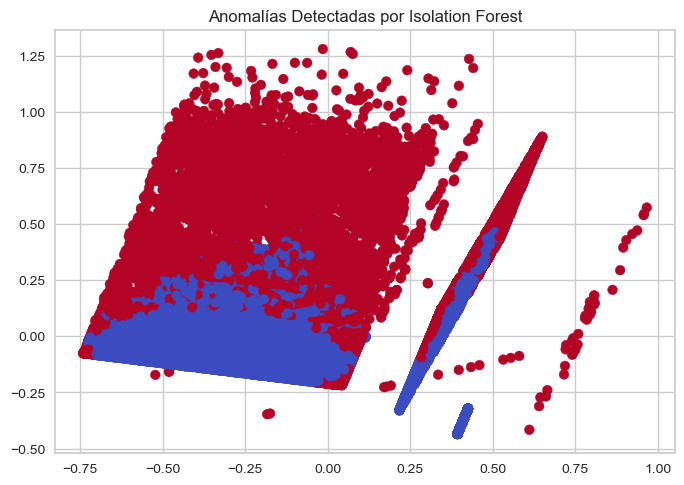

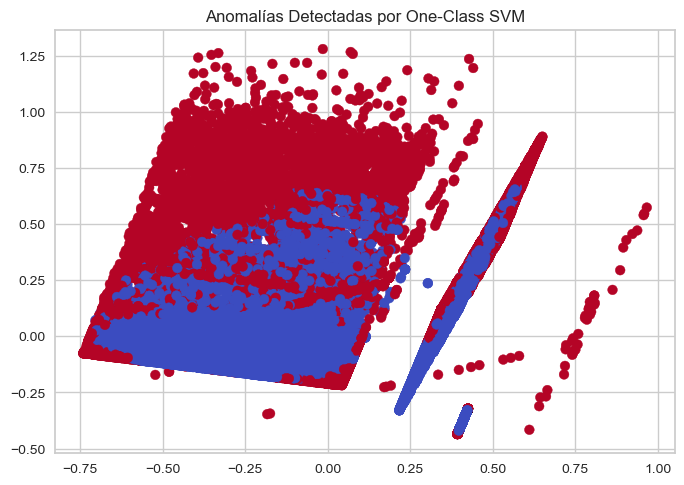

In [52]:
# Gráficos de dispersión para visualizar anomalías detectadas
plt.figure()
plt.scatter(combined_data.iloc[:, 0], combined_data.iloc[:, 1], c=combined_data['Anomaly_IF'], cmap='coolwarm', label='Isolation Forest')
plt.title('Anomalías Detectadas por Isolation Forest')
plt.show()

plt.figure()
plt.scatter(combined_data.iloc[:, 0], combined_data.iloc[:, 1], c=combined_data['Anomaly_OCSVM'], cmap='coolwarm', label='One-Class SVM')
plt.title('Anomalías Detectadas por One-Class SVM')
plt.show()

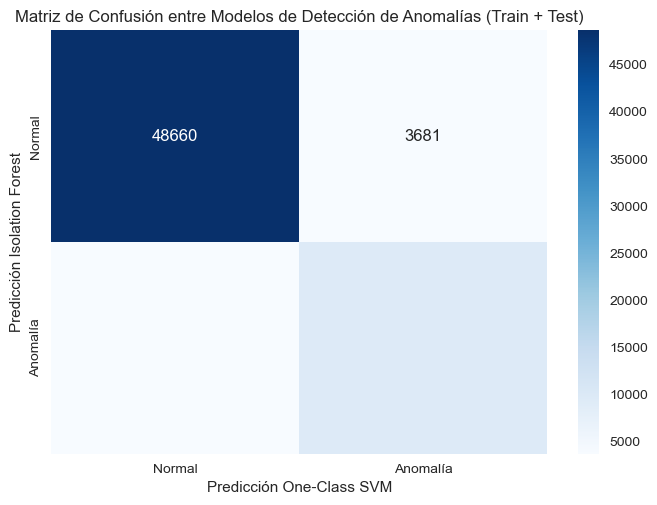

In [46]:
# Matriz de confusión entre modelos de detección de anomalías en el conjunto combinado
cm = confusion_matrix(combined_data['Anomaly_IF'], combined_data['Anomaly_OCSVM'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomalía'], yticklabels=['Normal', 'Anomalía'])
plt.xlabel('Predicción One-Class SVM')
plt.ylabel('Predicción Isolation Forest')
plt.title('Matriz de Confusión entre Modelos de Detección de Anomalías (Train + Test)')
plt.show()

# Clustering

### Numero de clusters

Metodo del codo

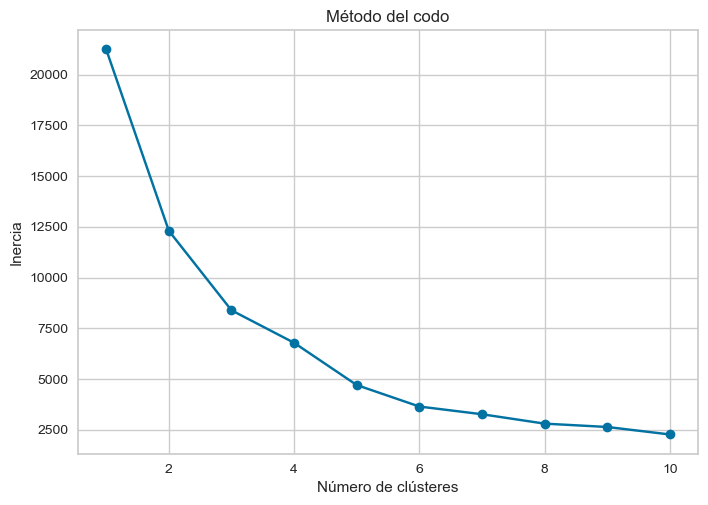

In [48]:
inercia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(components_df)
    inercia.append(kmeans.inertia_)

plt.plot(range(1, 11), inercia, marker='o')
plt.xlabel('Número de clústeres')
plt.ylabel('Inercia')
plt.title('Método del codo')
plt.show()

Meanshift

In [55]:
bandwidth = estimate_bandwidth(components_df, quantile=0.2)

modelo_meanshift = MeanShift(bandwidth=bandwidth, n_jobs = -1, cluster_all=False)
modelo_meanshift.fit(components_df)

centroides = modelo_meanshift.cluster_centers_
num_clusters = len(centroides)

print("Número estimado de clústeres mediante Mean Shift:", num_clusters)

Número estimado de clústeres mediante Mean Shift: 7


Silhouette

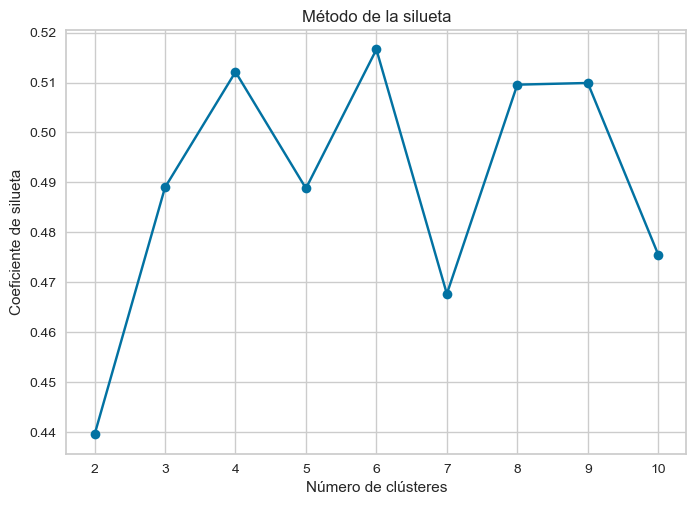

In [56]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(components_df)
    silhouette_avg = silhouette_score(components_df, labels)
    silhouette_scores.append(silhouette_avg)

plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Número de clústeres')
plt.ylabel('Coeficiente de silueta')
plt.title('Método de la silueta')
plt.show()

Analisis densidad

In [57]:
kde = KernelDensity(bandwidth=0.3)
kde.fit(components_df)

densidades = np.exp(kde.score_samples(components_df))
picos = np.where((densidades[1:-1] > densidades[:-2]) & (densidades[1:-1] > densidades[2:]))[0] + 1
num_clusters = len(picos)

print("Número estimado de clústeres mediante análisis de densidad:", num_clusters)

Número estimado de clústeres mediante análisis de densidad: 20607


### DBSCAN

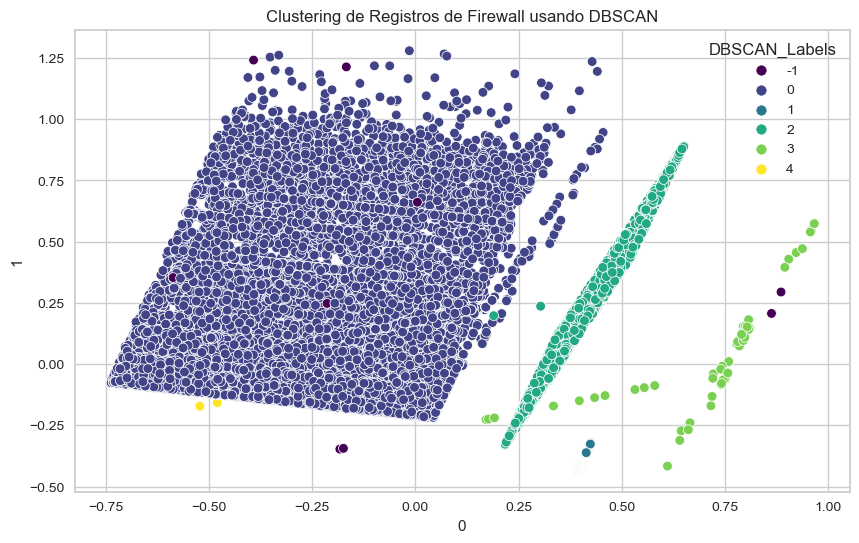

In [58]:
dbscan = DBSCAN(eps=0.30, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_selected_scaled)

components_df['DBSCAN_Labels'] = dbscan_labels

plt.figure(figsize=(10, 6))
sns.scatterplot(x=components_df[0], y=components_df[1], hue=components_df['DBSCAN_Labels'], palette='viridis')
plt.title('Clustering de Registros de Firewall usando DBSCAN')
plt.show()

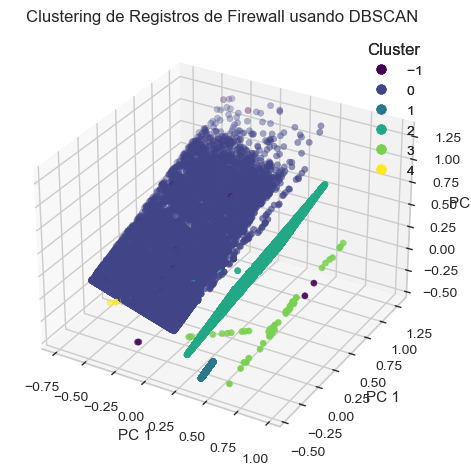

In [59]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(components_df.iloc[:, 0], components_df.iloc[:, 1], components_df.iloc[:, 1], c=components_df['DBSCAN_Labels'], cmap='viridis')
ax.set_title('Clustering de Registros de Firewall usando DBSCAN')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 1')
ax.set_zlabel('PC 3')
legend = ax.legend(*scatter.legend_elements(), title="Cluster")
ax.add_artist(legend)
plt.show()

In [62]:
df['DBSCAN_Labels'] = components_df['DBSCAN_Labels']

In [66]:
df.select_dtypes(include='number').columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received',
       'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received',
       'Action_encoded', 'DBSCAN_Labels'],
      dtype='object')

In [67]:
df.groupby('DBSCAN_Labels')[['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received',
       'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received',
       'Action_encoded']].mean()

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received,Action_encoded
DBSCAN_Labels,,,,,,,,,,,,
-1,44713.937500,22969.125000,38494.562500,15388.750000,1.602938e+08,8.122351e+07,7.907024e+07,159659.500000,3956.750000,82611.750000,77047.750000,0.75
0,51131.431142,4723.480786,33547.514484,4643.528755,1.009325e+05,4.392365e+03,9.654017e+04,110.516052,112.971431,36.230068,74.285984,0.00
1,57038.209244,445.000000,0.000000,0.000000,6.867528e+01,6.867528e+01,0.000000e+00,1.000000,0.000000,1.000000,0.000000,2.00
2,38549.326457,33922.139595,3.289605,2.125242,8.299092e+01,8.299092e+01,0.000000e+00,1.001602,0.000000,1.001602,0.000000,1.00
3,24189.980000,24311.640000,4659.480000,677.800000,1.540800e+02,1.400800e+02,1.400000e+01,1.600000,0.140000,1.400000,0.200000,3.00
4,53466.750000,75.000000,53466.750000,75.000000,4.966250e+02,1.676250e+02,3.290000e+02,4.125000,0.250000,2.125000,2.000000,1.00


<Axes: >

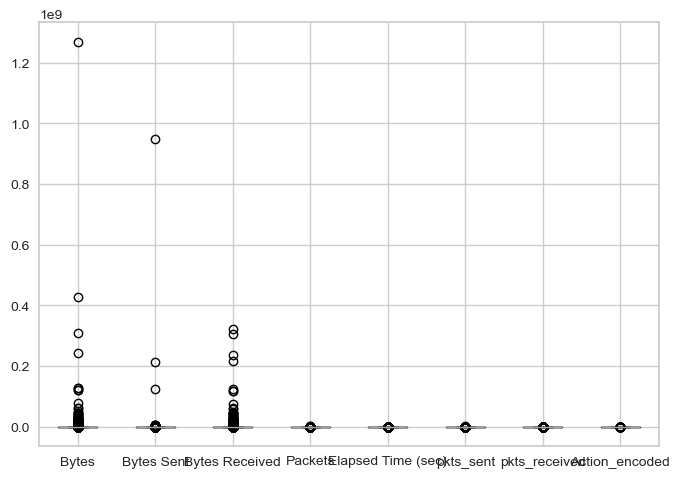

In [69]:
df[['Bytes', 'Bytes Sent', 'Bytes Received',
       'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received',
       'Action_encoded']].boxplot()

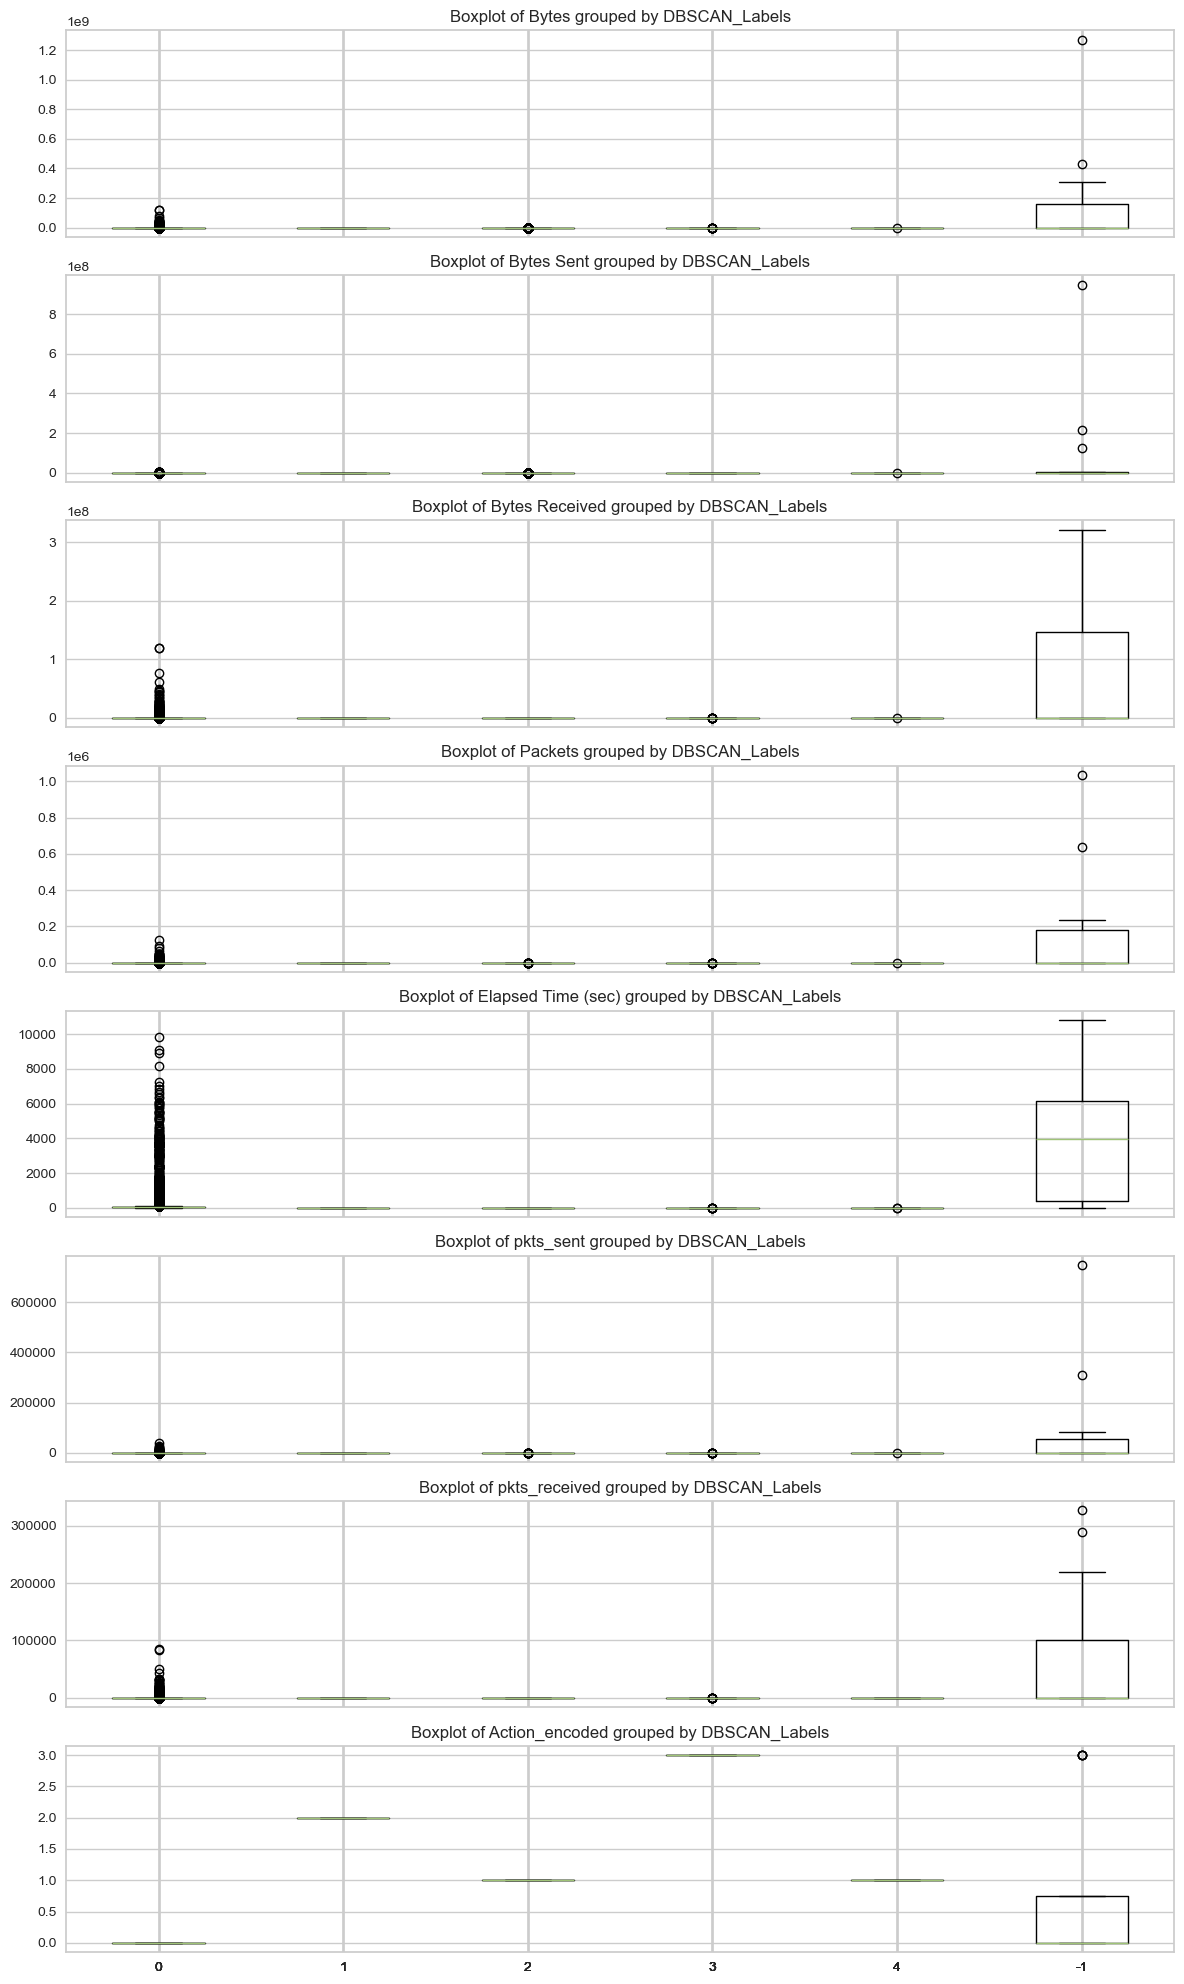

In [81]:
# Supongamos que ya tienes el DataFrame df
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar las columnas que deseas graficar
columns_to_plot = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 
                   'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Action_encoded']

# Obtener los valores únicos de la columna DBSACN_Labels para agrupar
labels = df['DBSCAN_Labels'].unique()

# Crear una figura con subplots
fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(12, 20), sharex=True)

for i, column in enumerate(columns_to_plot):
    # Crear una lista para almacenar los datos de cada grupo
    data_to_plot = []

    for label in labels:
        # Filtrar los datos del DataFrame por el valor del label actual
        data = df[df['DBSCAN_Labels'] == label][column].dropna()
        data_to_plot.append(data)

    # Crear el boxplot para la columna actual
    axes[i].boxplot(data_to_plot, labels=labels)
    axes[i].set_title(f'Boxplot of {column} grouped by DBSCAN_Labels')

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()

# Mostrar la gráfica
plt.show()


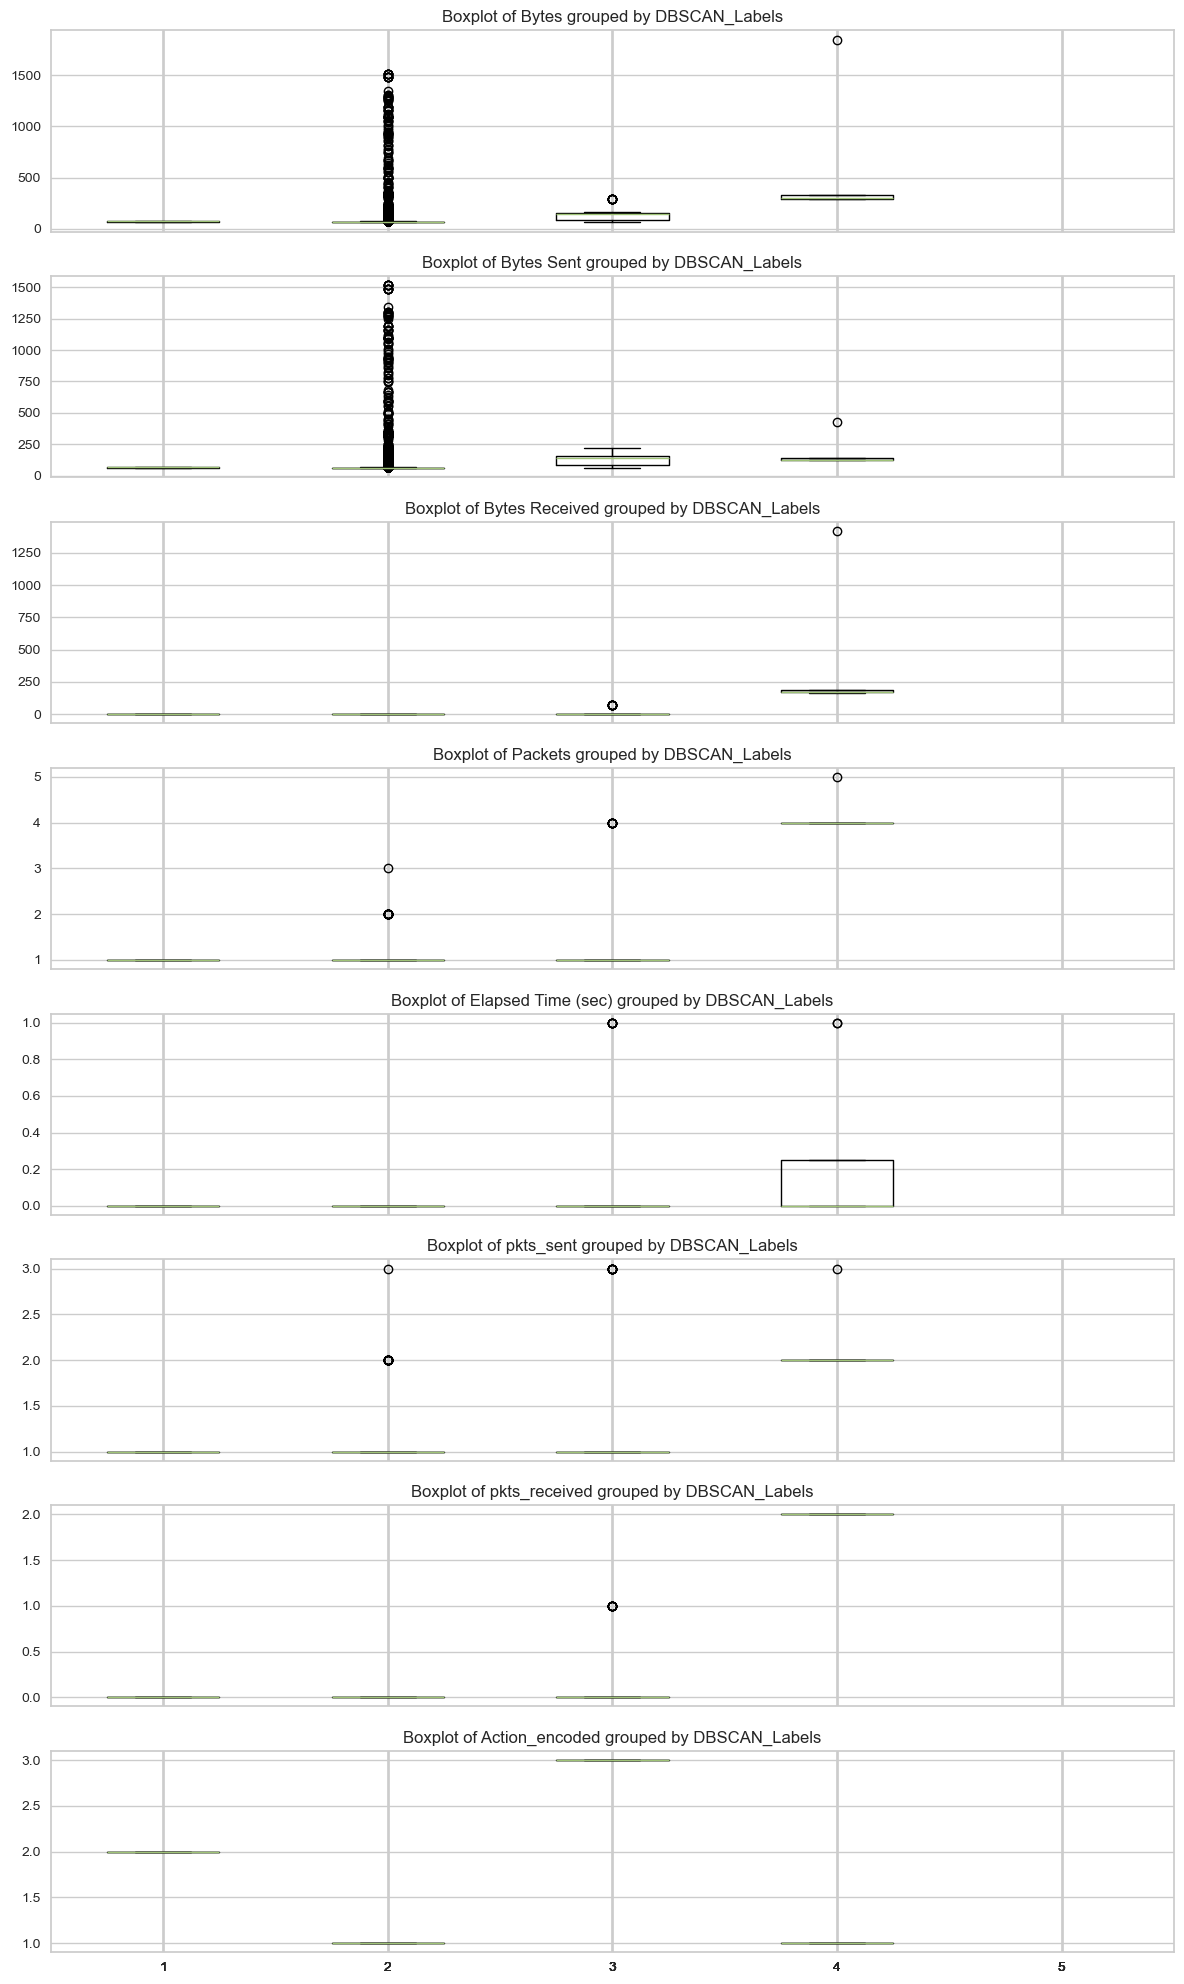

In [79]:
# Supongamos que ya tienes el DataFrame df
import pandas as pd
import matplotlib.pyplot as plt

# Filtrar las columnas que deseas graficar
columns_to_plot = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 
                   'Elapsed Time (sec)', 'pkts_sent', 'pkts_received', 'Action_encoded']

# Obtener los valores únicos de la columna DBSACN_Labels para agrupar
labels = [1,2,3,4,5]

# Crear una figura con subplots
fig, axes = plt.subplots(nrows=len(columns_to_plot), ncols=1, figsize=(12, 20), sharex=True)

for i, column in enumerate(columns_to_plot):
    # Crear una lista para almacenar los datos de cada grupo
    data_to_plot = []

    for label in labels:
        # Filtrar los datos del DataFrame por el valor del label actual
        data = df[df['DBSCAN_Labels'] == label][column].dropna()
        data_to_plot.append(data)

    # Crear el boxplot para la columna actual
    axes[i].boxplot(data_to_plot, labels=labels)
    axes[i].set_title(f'Boxplot of {column} grouped by DBSCAN_Labels')

# Ajustar el layout para que no se solapen los subplots
plt.tight_layout()

# Mostrar la gráfica
plt.show()
